<a href="https://colab.research.google.com/github/DiGyt/snippets/blob/master/entropy_based_measures_in_ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Click the above Google Colab link to run this notebook directly through your browser.**


---
# Entropy-based measures in Machine Learning
---
_Dirk Gütlin_

Machine Learning is a rapidly growing field that has revolutionized the way we approach problem-solving in the modern world. In order to create accurate and efficient models, it is necessary to understand and utilize a variety of mathematical concepts, including probability theory and information theory. While many scientists and students from natural sciences may have a background in classical statistics, they may not be as familiar with information-theory-based entropy measures in Machine Learning.

In this blog post, I will provide a comprehensive overview of entropy-based measures commonly used in Machine Learning. My aim is to make these concepts accessible and easy to understand, especially for people who do not have a strong background in information theory. The post covers the following concepts (check the table of contents on the left for details):

- Entropy
- Cross Entropy
- Relative Entropy (a.k.a. Kullback-Leibler Divergence)
- Information Gain and Conditional Entropy
- Mutual Information and Joint Entropy
- Gibbs Inequality (Bonus)

Each chapter includes an explanation of the concept, Python implementation, and examples of how to use the respective concept or function. The aim is to help you understand how these measures work, and to give you very low level Python implementations for any of these concepts whenever you need them.

By the end of this post, you will have a solid understanding of these entropy-based measures and how they can be applied to problems in Machine Learning. So, let's dive in and explore the most relevant entropy-based measures in Machine Learning!

In [ ]:
# import and set random seeds
import numpy as np
import matplotlib.pyplot as plt
import warnings
import logging

# ignore wanrnings & set random seed
logging.getLogger('matplotlib').setLevel(logging.ERROR)
warnings.filterwarnings('ignore')
np.random.seed(2311)

# set plot style to anything in plt.style.available or "xkcd"
PLT_STYLE = "xkcd"

# Let's prepare a simple plotting function as we will use this frequently
def plot_probabilities(probabilites, x_values=None, x_label="Outcome",
                       y_label="Probability", plt_type=plt.bar, **kwargs):
  """Plots discrete probabilities in a bar chart."""

  # set x_value default as number range starting from 1
  if isinstance(x_values, type(None)):
    x_values = np.arange(1, len(probabilites) + 1)

  # convert to tuple to support multiple probability args (for 2d plots)
  if not isinstance(x_values, tuple):
    x_values = (x_values, )

  # plot with style
  style = plt.xkcd() if PLT_STYLE == "xkcd" else plt.style.context(PLT_STYLE)
  with style:
    plt_type(*x_values, probabilites, **kwargs)
    plt.xlabel(x_label)
    plt.ylabel(y_label)


# Recap

### Discrete Probabilities

All of the measures presented in this notebook are measure designed for *discrete* (or *discretized*) random variables.

Discrete random variables are random variables with a limited set of outcomes, meaning that we can assign a probability to each outcome and that the probability of all outcomes combined should sum up to a total probability of $p=1$. One example is the outcome of a dice roll. We all know that a die has 6 different outcomes $[1, 2, 3, 4, 5, 6]$. In a perfect die, each of these outcomes are equally likely, giving each outcome a probability of $\frac{1}{6}$. Accordingly we can model the distributions of a dice roll as:

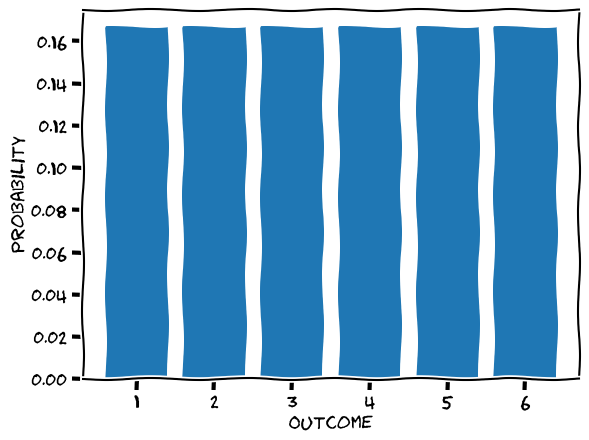

In [ ]:
# define probabilities for each outcome
p_x = np.array([1/6, 1/6, 1/6, 1/6, 1/6, 1/6])

# plot probabilites
plot_probabilities(p_x)

Of course, this distribution is still pretty boring. A 2-dice roll would be already more interesting as the distribution of outcomes follows a binomial distribution.

If we want to model continuous distributions such as a gaussian, we can *discretize* these continuous distributions (e.g. in a histogram), where there is a fixed number of bins (*outcomes*) that we can divide our distribution into. Here, we divide a continuous gaussian distribution by counting the occurences within 30 equally spaced bins between -3 and 3.

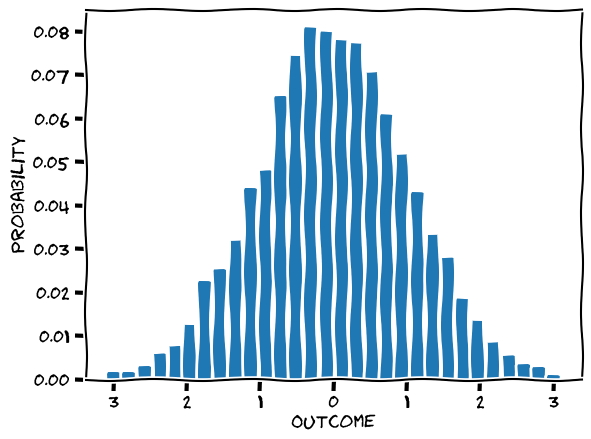

In [ ]:
# create normally distributed data
x = np.random.normal(0, 1, 10000)

# discretize by converting into a histogram of 50 bins between values [-3, 3]
p_x, _ = np.histogram(x, bins=30, range=(-3, 3))

# convert frequencies to a probability density with a sum of p=1
p_x = p_x / np.sum(p_x)

# plot bar chart
plot_probabilities(p_x, x_values=np.linspace(-3, 3, 30), width=0.15)


So, for visual learners: discrete distributions are distributions that can be represented as histograms/bar charts.

In Machine Learning, you will encounter discrete or discretized random variables in things like one-hot encodings or softmax distributions which are universally used in classification tasks (notably in Computer Vision and Natural Language Processing), but also in Reinforcement Learning (In discrete state/action spaces), as well as in bayesian networks, markov chains, or other graph-like objects...

### Expected Values

The main measure with which we'll be dealing with, **Entropy**, is a sort of expected value. Accordingly, it might help to revisit the formula for expected values in probability theory. We can calculate the Expected Value using the following function:

$EV(X) = \sum_i P(X_i)*X_i$

Where $X$ is a random variable and $P(X)$ is the probability of $X$. For a single dice roll, we can calculate the Expected Value as follows:

In [ ]:
# define function to calculate EV
def expected_value(p_x, x):
  return np.sum(p_x * x)

# define the values of possible outcomes and their respective probabilities
x = np.array([1,    2,    3,    4,    5,    6])
p_x = np.array([1/6,  1/6,  1/6,  1/6,  1/6,  1/6])

# print
EV = expected_value(p_x, x)
print("Expected Value: {:.3f}".format(EV))

Expected Value: 3.500


Of course this might seem very basic. But it's a good foundation for what's coming. Now that we got this covered, let's move on to the actual topic.

# Entropy


### Introduction

First, let's clear up some questions concerning the measure of Entropy that we use:

</br>

### Is this the same Entropy we know from physics?


Most of us probably know Entropy as a term stemming from physics. In physics (notably in thermodynamics), Entropy measures the level of decay in a physical system.

However, the entropy used in machine learning is not exactly the same, at least it was not intended as such. The entropy measure that machine learning uses was invented by Claude Shannon, known as Shannon Entropy, to describe the amount of uncertainty or randomness in a set of data. In fact, Shannon initially didn't even know what to call this new measure. The fact that it's also called Entropy is due to a meeting with John von Neuman who pointed out the measure's similarities to the physical Entropy. A famous anecdote reported in Tribus & McIrvine (1971) describes Shannon's conversation with Neuman:

> *My greatest concern was what to call it. I thought of calling it 'information,' but the word was overly used, so I decided to call it 'uncertainty.' When I discussed it with John von Neumann, he had a better idea. Von Neumann told me, 'You should call it entropy, for two reasons: In the first place your uncertainty function has been used in statistical mechanics under that name, so it already has a name. In the second place, and more important, no one really knows what entropy really is, so in a debate you will always have the advantage.'*

Of course there are striking similarities between the concepts of physical entropy and shannon entropy, and if you have a good grasp of these concepts, I think it's adequate to treat them as a conceptually similar thing. However, for starters it can help to recognize that the Entropy we're dealing with here has a different history of origin than its physical counterpart.

</br>

### How do we calculate Entropy?

Entropy in information theory (**Shannon Entropy**) is actually a relatively simple concept. It aims to describe the **average uncertainty** in a dataset or distribution of data. Let's just have a look at the formula. This is the one that we see all around Machine Learning:

$H(X) = - \sum_i P(X_i) * log(P(X_i))$

Looks weird? It's actually all pretty easily explainable. Let's consider another form of the Entropy formula:

$H(X) = \sum_i P(X_i) * log(\frac{1}{P(X_i)})$

This is actually the very same formula as the one above, just reshaped. The former version is just quicker to calculate, but the latter helps us to understand what's going on here. <font color="DodgerBlue">If you're interested in how to get from one to the other, have a look at the appendix.</font> The reason we're looking at this form of the Entropy formula is because its more intuitively explainable. Let's divide the formula into three terms, so we can understand each of them separately:

$H(X) =$ <font color="orange"> $\sum_i P(X_i) *$ </font> <font color="green"> $log($ </font> <font color="red"> $\frac{1}{P(X_i)}$ </font><font color="green"> $)$ </font>

Let's look at the </font> <font color="orange"> $\sum_i P(X_i) * ...$ </font> part first. This part just looks exactly the same like in the formula for the Expected Value from above. This means that the Entropy is a sort of Expected Value measure. However, it doesn't measure the *expected outcome value* as weighted by their probabilities, but something else. What does it measure? Well, it should measure some sort of information uncertainty, right? Exactly. Let's start with the uncertainty part. Uncertainty here is just defined as the *inverse of probability* <font color="red"> $\frac{1}{P(X_i)}$ </font>. Makes sense right? If not, consider that the higher the probability for a certain state, the easier it is to predict which means there's less uncertainty.

Example: Imagine you are communicating with a friend sending Morse codes (let's assume that the signal at any given time can be $short$ or $long$). Now, your friend is just always sending $[long, long, long, long, long, ...]$, i.e. your probability of receiving a $long$ at any given time is $p(long)=1$. This means two things:
1. There is no uncertainty about the next state at all, as you know it will most probably be a $long$.
2. There is also no information to gain from the signal. If your friend just always sends $long$, there's no way that the Morse signal itself encodes any message.

However, taking the inverse of probability <font color="red"> $\frac{1}{P(X_i)}$ </font> as a measure for uncertainty alone is not enough. If your friend is always sending $long$, there is absolutely no uncertainty in the signal. So the uncertainty of $\frac{1}{P(long)}$ should be $0$. However, only using the inverse probability we get an uncertainty of $\frac{1}{1}=1$. And that's where the <font color="green">$log(...)$</font> part comes in handy. If we use <font color="green"> $log($ </font> <font color="red"> $\frac{1}{P(X_i)}$ </font><font color="green"> $)$ </font> rather than just <font color="red"> $\frac{1}{P(X_i)}$ </font> we get exactly the behavior that we want, i.e. that $log(\frac{1}{P(long)})=0$. Let's get a better intuition for the $log(1/p)$ function by having a look at it:

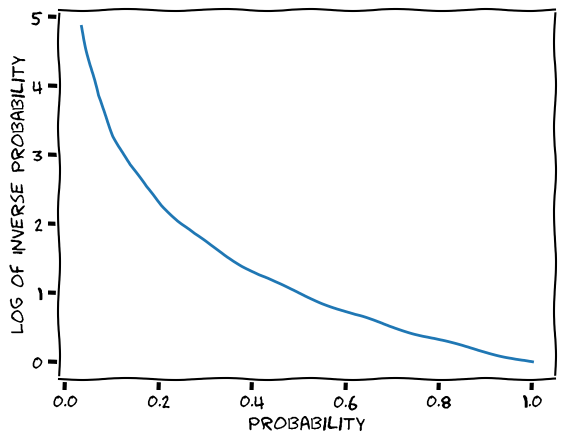

In [ ]:
# plot log(1/x) over probabilities from 0 to 1
p_space = np.linspace(0, 1, 30)
log_p_space = np.log2(1 / p_space)
plot_probabilities(log_p_space, x_values=p_space, x_label="Probability",
                   y_label="Log of Inverse Probability", plt_type=plt.plot)

Here, we see clearly that the $log(1/p)$ goes to $0$ for $p \to 1$ and goes to $\infty$ for $p \to 0$. So an event with high probability of occurring (=certainty) has low uncertainty while a very unlikely event has a very high uncertainty.
Another beneficial property of using the <font color="green">$log(...)$</font> here is that the log function is continuous between 0 and 1, monotonous, and additive, which means that $log(x) + log(y) = log(x*y)$. So for example in the above function $f(0.5) = 1$ which means that $f(0.5) + f(0.5) = 2$. This matches our observation if we look at the function at $f(0.5 * 0.5) = f(0.25) = 2$. This property comes in handy when we're dealing with probabilities, where the probability of observing $x$ and $y$ at the same time is equal to the joint probability of observing $xy$. In his book *A Mathematical Theory of Communication*, Claude Shannon also mentions other reasons for picking the log for this metric, one being the fact that it seems "the proper measure" to deal with information. As for example adding 1 bit of information to a binary string adds 1 to the base 2 logarithm to the number of possible states of that string (meaning that it doubles them).

</br>

### Which log should I use?

This is actually totally up to you, as long as it is a log. Changing the base merely changes the 'unit' of information you're dealing with. For obvious reasons, the base 2 logarithm is very popular in Computer Sciences, with the unit of information being measured in "bit" (aka "shannon"). However, a large part of Machine Learning simply uses the natural logarithm instead, here the unit of information would be called "nit". Another less popular choice is the base 10 logarithm, where the information unit would be called "hartley", "dit", or "ban".

Throughout this notebook, we will stick to the base 2 logarithm, simply because "bits" are the most popular unit in information theory. However, this is of little relevance for practical applications.




### Python Example 1: Fair Coin Toss

But enough of the theory. We learn by doing, so let's look at how the Entropy function behaves for some different examples:

In [ ]:
# define Entropy function
def entropy(p):
  """Calculate the Entropy of a distribution."""
  return -np.sum(p * np.log2(p))

# define the discrete probabilites for either heads or tails
p = np.array([0.5, 0.5])

# Calculate the Entropy of this distribution
H = entropy(p)
print("Entropy: {:.3f} bits".format(H))

Entropy: 1.000 bits


Since there are only two possible outcomes, the maximum entropy is achieved when the probability of each outcome is 0.5, which gives us an entropy of exactly $H = 1$ bit. Now try the above example with a loaded coin (e.g. using the probabilities `[0.3, 0.7]`). We can see that the Entropy decreases to $H \approx 0.88$. Why? Because the outcome distribution is now *more predictable* and therefore *less uncertain*.

### Python Example 2: Loaded Die

Suppose we have a loaded six-sided die, where instead of equally likely outcomes of $\frac{1}{6}$, The likelihood for a 6 is 2 times as likely ($\frac{2}{6}$), while the chance of rolling a 1 or a 2 is only half as likely ($\frac{1}{12}$). Feel free to play around with this example and change the the probabilities to get an intuition.

Entropy: 2.418 bits


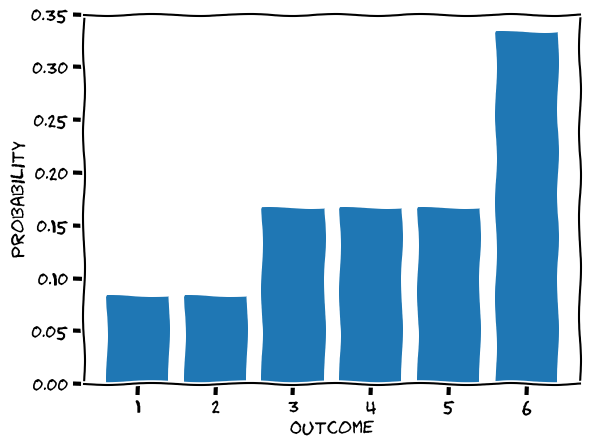

In [ ]:
# define and plot probability distribution
p = np.array([0.5/6, 0.5/6, 1/6, 1/6, 1/6, 2/6])
plot_probabilities(p)

# Calculate Entropy
H = entropy(p)
print("Entropy: {:.3f} bits".format(H))

While playing, You might notice 2 things:
1. The log of 0 is not defined. This makes sense for our Entropy calculation. If one outcome is **never** going to happen, it doesn't make sense to include it in our probability distribution at all. Accordingly, zero-probabilities will lead to `nan` values when calculating the Entropy.
2. One important property of discrete probability distributions is that the sum of all possible outcomes needs to be equal 1. Make sure that this is the case for your loaded dice distribution. If this requirement is not fulfilled, the Entropy might return meaningless outcomes such as negative Entropies. To make sure your outcomes sum up to one you can add a normalization such as `p = p / np.sum(p)`.

### Conclusion

In this chapter, we investigated at how entropy works, its theory, its history, and gained some intuition for the measure using different examples.If you played around with the examples a bit, You might have gained 2 great intuitions about Entropy:
1. Having more possible outcomes means overall more Entropy. There is inherently more uncertainty in choosing from 6 different outcomes than in choosing from 2 different outcomes.
2. The Entropy (for a given number of outcomes) is largest when all outcomes are equally likely. This also makes sense, as this is the distribution with the most uncertainty. On a truly random die, you have no idea what outcome should come next. If single outcomes are more likely than others, this adds clues about which outcomes to predict, which reduces the overall uncertainty.

If you followed up until here, You made the hardest part already. All subsequent metrics are based on Entropy and are relatively easy to understand if you have grasped the general concept behind Entropy.

# Cross-Entropy

### Introduction

Cross-entropy is a measure of the difference between two probability distributions. Cross-entropy is probably most widely known in Machine Learning as objective function for supervised classification tasks. Here, we will investigate the concept of cross-entropy and see how it is calculated.

### Calculation

The cross-entropy between two probability distributions p(x) and q(x) is given by:

$ CE(p,q) = -\sum_{i=1}^n p(x_i) \log q(x_i) $

where n is the number of possible outcomes of the distributions. Note that this function is exactly the same as the Entropy function, except for the fact that with Cross-entropy, we do not look at one single distribution, but we calculate the expected value of one distribution p with another log distribution q. This neat little twist represents the _number of bits required to encode a distribution p using code designed to represent a distribution q_. The concept is often applied in contexts where we have a _true distribution p_ and an _approximated distribution q_, as in your typical supervised classification task. In that context, the Cross-entropy is minimized by adjusting the parameters of a model to better approximate the true distribution.

Note that The cross-entropy is a non-negative quantity, and is non-symmetric, which means that $CE(p,q) \neq CE(q,p)$, except if $p(x) = q(x)$, in which case the cross-entropy is equal to 0.

### Python Example

Let's assume we're building a weather forecasting model. We want to predict the probability of rain for a given date. Our variable `p` represents the actual probability of rain over that given date, while our variable `q` represents the probabilities that our model predicted. By calculating the cross-entropy, we can quantify how close our model is to the actual distribution:

Cross-Entropy: 1.122 bits


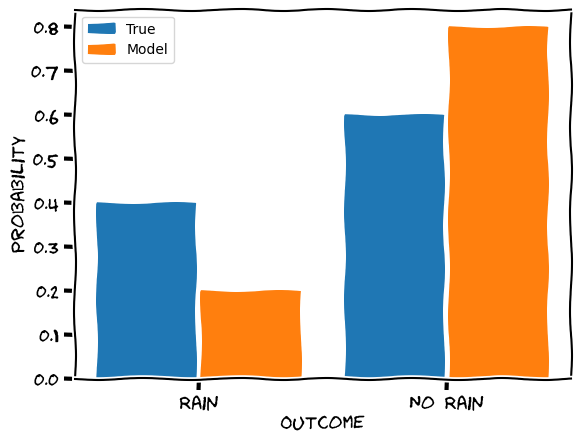

In [ ]:
# define Cross-Entropy function
def cross_entropy(p, q):
  """Calculate Cross-Entropy between two distributions."""
  return -np.sum(p * np.log2(q))

# define true (p) and predicted (q) probabilities for the possible outcomes
p = np.array([0.4, 0.6])
q = np.array([0.2, 0.8])

# calculate Crossentropy
CE = cross_entropy(p, q)
print("Cross-Entropy: {:.3f} bits".format(CE))

# plot
names = np.array(["Rain", "No Rain"])
ticks = np.arange(len(names))
plot_probabilities(p, ticks-0.21, width=0.4, label='True')
plot_probabilities(q, ticks+0.21, width=0.4, label='Model')
plt.xticks(ticks, names)
plt.legend();

### Conclusion

In this chapter, we have learned about the concept of cross-entropy as a measure of the difference between two probability distributions. We have seen how cross-entropy is calculated and how it's related to Entropy. Finally, we have seen how cross-entropy can be applied in practical scenarios to quantify how close a model's predicted probabilities are to the actual distribution.

# Relative Entropy (Kullback-Leibler Divergence)



### Introduction

Relative Entropy, also known as Kullback-Leibler (KL) Divergence, is a measure of the difference between two probability distributions. It is a concept from information theory that has been widely used in machine learning for tasks such as model comparison, feature selection, and clustering. In this chapter, we will introduce the concept of relative entropy, explain how it is calculated, and show some examples of its use.

### Calculation

The KL divergence between two probability distributions p(x) and q(x) is given by:

$ D_{KL}(p||q) = \sum_i p(x_i) \log (\frac{p(x_i)}{q(x_i)}) $

where n is the number of possible outcomes of the distributions. The first thing you might notice is the relative entropy's relation to the above stated entropy as well as the crossentropy, if we reshape it in the same way:

$H(x) = \sum_i p(x_i) \log(\frac{1}{p(x_i)}); \quad  CE(p,q) = \sum_i p(x_i) \log (\frac{1}{q(x_i)}) $

This can help us to understand the differences between the three. While the entropy is a measure of uncertainty for one probability distribution and the crossentropy is the uncertainty of a probability distribution approximated by "plugging in" a second probability distribution as an estimate, the relative entropy goes one step further and expresses the distance between two distributions as a ratio between them. Another way to understand the relation between these three measures is via the following formula:

$D_{KL}(p||q) = CE(p,q) - H(p)$

This formula makes it pretty clear that the relative entropy (KL-divergence) represents a very similar to cross-entropy except for the fact that the KL-divergence has the original entropy 'removed'. Also similar to the Cross-Entropy, the KL divergence is strictly positive and not symmetric, i.e., $D_{KL}(p||q) \neq D_{KL}(q||p)$.


### Python Example

Let's use this example to compare two typical distributions: The gamma distribution and the gaussian distribution. First, we define a gamma(5, 1) distribution `p`. Imagine you want to approximate the gamma distribution using the gaussian distribution `q`. Relative Entropy/KL Divergence is a great tool to measure how much 'distant' these two distributions are from each other:

Relative Entropy (KL Divergence): 0.288 bits


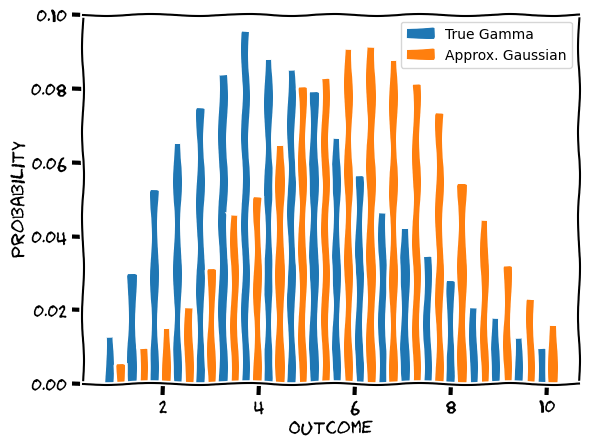

In [ ]:
# define KL divergence
def relative_entropy(p, q):
  """Calculate Relative Entropy / KL Divergence between two distributions."""
  return np.sum(p * np.log2(p/q))

# Let's write a function to create discrete distributions from samples
def discretize_distribution(samples, bins, range=None, joint_dist=False,
                            add_constant=0):
  """Calculates the discrete distribution of random samples via histogram."""
  p, _ = np.histogramdd(samples, bins=bins, range=range)
  p = p + add_constant  # optionally add a tiny constant to omit 0-probabilities
  p = p / np.sum(p)  # Normalize to a total probability of 1
  return p

# define the space for our discrete distributions
p_min, p_max, n_p = 1, 10, 20
p_space = np.linspace(p_min, p_max, n_p)

# define the true distribution as a gamma(5, 1) distribution
p = np.random.gamma(5, 1, 10000)
p = discretize_distribution(p, bins=n_p, range=[(p_min, p_max)])

# define the approximate distribution as a normal(6, 2) dist
q = np.random.normal(6, 2, 10000)
q = discretize_distribution(q, bins=n_p, range=[(p_min, p_max)])

# calculate the relative Entropy/ KL Divergence
D_kl = relative_entropy(p, q)
print("Relative Entropy (KL Divergence): {:.3f} bits".format(D_kl))

# plot the distributions
plot_probabilities(p, p_space-0.12, width=0.15, label='True Gamma')
plot_probabilities(q, p_space+0.12, width=0.15, label='Approx. Gaussian')
plt.legend();

Feel free to play around with the parameters of the distributions to get some intuition. Can you manually find a value that minimizes the relative Entropy?

### Conclusion

In this chapter, we learned about Relative Entropy or KL Divergence. We learned about the concept behind it, how it is calculated and how it is related to the concepts of entropy and cross-entropy. Additionally, we saw how it can be used to calcualte the divergence between different discrete distributions.

After seeing Cross-Entropy denoted as $CE(p, q)$ and Relative Entropy denoted as $D_{kl}(p || q)$ you might think of typical probability notation and wonder whether these metrics represent something like a *joint Entropy* and a *conditional Entropy* respectively. The answer is no, not directly. Although both of these concepts actually exist and are partly related to Cross-Entropy and Relative Entropy. In the next chapters, we will actually use conditional Entropy and joint Entropy to calculate Information gain and Mutual Information between two variables.

# Information Gain and Conditional Entropy

### Introduction


Information gain is another Entropy-based measure that is frequently used in Machine Learning. It measures how much information a particular feature contributes to a prediction. In machine learning, information gain is often used to select the most relevant features for a given task. The basic idea behind information gain is to measure the reduction in entropy that results from splitting the data based on a given feature. A feature that results in a large reduction in entropy is said to have high information gain and is likely to be useful for making predictions. In this way, information gain provides a quantitative measure of the importance of a feature for a given task, which makes it a valuable measure for tasks like feature selection or decision tree learning.

### Calculation

We can calculate the information gain of a feature using the concept of conditional entropy: Let's consider a joint distribution $p(X,Y)$ of two random variables $X$ and $Y$, specifying the probability of $X$ taking on the value $x_i$ and $Y$ taking on the value $y_j$. The conditional entropy of $Y | X$ is given by:

$ H(Y|X) = -\sum_i \sum_j p(x_i,y_j) \log \frac{p(x_i,y_j)}{p(x_j)} $

From this conditional entropy, we can calculate the information gain of variable $Y$ with respect to $X$ via:

$ IG(Y|X) = H(Y) - H(Y|X) $

The information gain describes the reduction in uncertainty about $Y$ that results from gaining knowledge about $X$.


> <font color="DodgerBlue">**NOTE**: When dealing with conditional and joint Entropy, we should remember that conditional and joint probabilities can be easily reshaped using the marginal sum rule $P(X) = \sum_{y \in Y}P(X,Y) $ and the chain rule of probabiltiy: $P(X, Y) = P(X | Y) * P(Y)$. This can help us to easily calculate Entropies from different constellations of conditional or joint probabilities. However, this also leads to several different variants of formulae for conditional entropy, information gain, and mutual information. So it might be that you come across a large range of differently looking formulae. However they all should actually lead to the same results. </font>

### Python Example

Let's consider a simple example of two random variables $X$ and $Y$, where $X$ can take 3 different values and $Y$ can take 2 different values.

In [ ]:
def conditional_entropy_from_marginal(p_y_given_x, p_x):
  """Calculates conditional entropy from conditional and marginal probability."""
  H_cond = cross_entropy(p_x * p_y_given_x, p_y_given_x)
  # equivalent forms
  # H_cond = -relative_entropy(p_y_given_x * p_x, p_x)
  # H_cond = -np.sum(p_x * (np.sum(p_y_given_x.T * np.log2(p_y_given_x.T), axis=1)))
  return H_cond

def conditional_entropy(p_xy):
  """Calculates conditional p(y|x) entropy from joint probability p(x,y)."""
  p_x = np.sum(p_xy, axis=1)  # get marginal probability of x
  return -relative_entropy(p_xy.T, p_x)

def information_gain(p_xy):
  """Calculates information gain from join probability."""
  p_y = np.sum(p_xy, axis=0)  # get marginal probability of y
  return entropy(p_y) - conditional_entropy(p_xy)


p_x = np.array([0.4, 0.3, 0.3])
p_y_given_x = np.array([[0.1, 0.6, 0.8],
                        [0.9, 0.4, 0.2]])
p_xy = (p_y_given_x * p_x).T  # joint distribution from conditional


print("Information gain: {:.3f} bits".format(information_gain(p_xy)))

Information gain: 0.300 bits


### Conclusion

In this chapter, we learned about information gain, which is a measure used in machine learning to determine the relevance of a feature for a given task. We saw that information gain measures the reduction in entropy that results from splitting the data based on a given feature, and that a feature with high information gain is likely to be useful for making predictions. We also learned how to calculate the information gain of a feature using conditional entropy. Overall, understanding information gain is important for tasks like feature selection or decision tree learning, where we need to identify the most relevant features to use in our models.

# Mutual Information and Joint Entropy

### Introduction

Mutual information is a measure of the amount of information that two random variables share. More precisely, Mutual Information is the reduction in uncertainty about X that results from gaining knowledge about Y, or vice versa. As such, Mutual Information is widely used in machine learning for tasks such as feature selection and clustering. It is also frequently used in finance to investigate predictability from one variable to another. In this chapter, we will introduce the concept of mutual information, explain how it is calculated, and show its relation to entropy and information gain.

### Calculation

Let's consider two random variables X and Y. The mutual information between X and Y is given by:

$ I(X;Y) = H(X) + H(Y) - H(X,Y) $

Here, $H(X)$ and $H(Y)$ are the entropies of the marginal distributions of $X$ and $Y$, respectively, while $H(X,Y)$ is the joint entropy of $X$ and $Y$. The joint entropy $H(X,Y)$ is calculated as:

$ H(X,Y) = -\sum_i \sum_j p(x_i,y_j) \log p(x_i,y_j) $

where $p(x_i,y_j)$ is the joint probability of $X$ taking on the value $x_i$ and $Y$ taking on the value $y_j$. As such, Mutual information is related to entropy in that it measures the reduction in uncertainty about one variable when we gain information about another variable. If the mutual information between two variables is high, it means that knowing the value of one variable can help us predict the value of the other variable with greater accuracy. Conversely, if the mutual information is low, the variables are relatively independent and knowing the value of one variable does not provide much information about the other variable.

Another way is to define the Mutual Information as the relative entropy / KL-Divergence of the joint distribution with the outer product of the marginal distributions:

$I(X;Y) = D_{kl}(X,Y || X \otimes Y )$

We can use either of these definitions of mutual entropy for our calculations in Python.

### Python Example

Mutual information is often used to compare predictability between two variables in finance. In our example, we will create an example for this and calculate the mutual information between two correlated variables. First, let's create and visualize the variables.

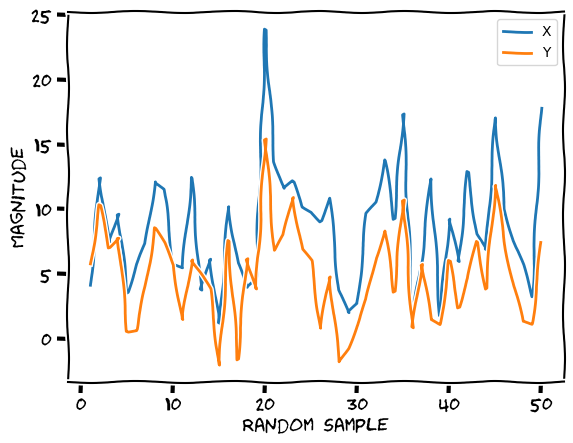

In [ ]:
# define two partially correlated random variables
x = np.random.gamma(3, 3, 10000)
y = np.random.normal(0, 2, 10000) + 0.6 * x

# plot the single samples to check to correlation
plot_probabilities(x[:50], plt_type=plt.plot, x_label="", y_label="")
plot_probabilities(y[:50], plt_type=plt.plot, x_label="Random Sample",
                   y_label="Magnitude")
plt.legend(["X", "Y"]);
#plot_probabilities(x, y, plt_type=plt.scatter, x_label="X", y_label="Y")

Now we can discretize them and calculate the mutual information between them.

Mutual Information: 0.327 bits


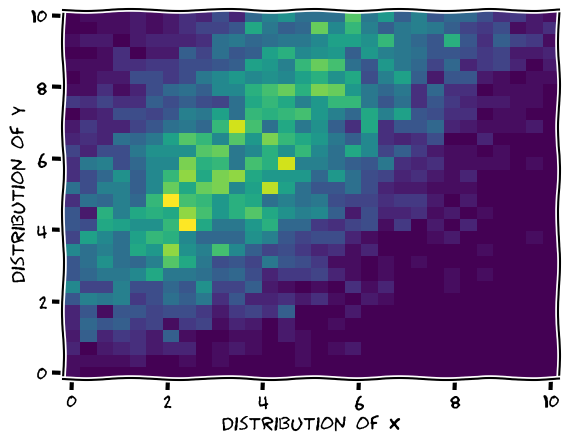

In [ ]:
def mutual_information(p_xy):
  """Calculate the Mutual Information between two variables."""
  # reconstruct the (marginal) distributions of x and y from xy
  p_x = np.sum(p_xy, axis=0)
  p_y = np.sum(p_xy, axis=1)

  # calculate mutual information
  #mi = relative_entropy(p_xy, np.outer(p_y, p_x))  # alternate form
  mi = entropy(p_x) + entropy(p_y) - entropy(p_xy)
  return mi

# define the spacein which we'll work
p_min, p_max, n_p = 0, 10, 30
p_space = np.linspace(p_min, p_max, n_p)

# calculate densities of marginal and joint distribution
p_xy = discretize_distribution((x, y), bins=n_p, joint_dist=True,
                               range=[(p_min, p_max)] * 2, add_constant=1e-20)

# plot the 2D joint distribution
plot_probabilities(p_xy, x_values=(p_space, p_space), plt_type=plt.pcolormesh,
                   x_label="Distribution of x", y_label="Distribution of y")

# mutual information
print("Mutual Information: {:.3f} bits".format(mutual_information(p_xy)))

### Conclusion

In this chapter, we introduced the concept of mutual information and explained how it is calculated using the entropies of the marginal distributions and the joint entropy of two random variables. We learned what Mutual Information means conceptually, how it's calculated and additionally, went through a Python example, using Mutual Information to compare predictability between two variables.

# Bonus: Gibbs' Inequality

### Introduction

Gibbs' inequality is a fundamental result from information theory that provides an upper bound on the entropy of a probability distribution. In the context of machine learning, Gibbs' inequality is important for understanding the tradeoff between accuracy and uncertainty in predictive models. In this chapter, we will introduce the concept of Gibbs' inequality, explain how it is derived, and discuss its implications for machine learning.

### Theorem

Gibbs' inequality states that for any probability distribution $p(x)$, the entropy H(p) is bounded by:

$ H(p) \leq -\sum_{x} p(x) \log q(x) $

where $q(x)$ is any probability distribution over the same space as $p(x)$. The equality holds if and only if $p(x) = q(x)$ for all $x$.

### Proof

The proof of Gibbs' inequality is based on the Jensen's inequality. The Jensen's inequality states that for any concave function f and any probability distribution $p(x)$:

$ f\left( \sum_{x} p(x) y(x)\right ) \geq \sum_{x} p(x) f(y(x)) $

where $y(x)$ is any real-valued function. The entropy of a probability distribution $p(x)$ is a concave function of the probabilities $p(x)$. Therefore, we can apply the Jensen's inequality to the logarithm function to obtain:

$ \log\left(\sum_{x} p(x) q(x)\right) \geq \sum_{x} p(x) \log q(x) $

where $q(x)$ is any probability distribution. By rearranging the terms, we obtain:

$ -\sum_{x} p(x) \log q(x) \geq -\log\left(\sum_{x} p(x) q(x)\right) $

The right-hand side of this inequality is known as the cross-entropy between $p(x)$ and $q(x)$. The inequality implies that the entropy of $p(x)$ is always smaller than or equal to the cross-entropy between $p(x)$ and $q(x)$, with equality holding if and only if $p(x) = q(x)$ for all $x$.

### Python Example

Gibbs' inequality implies that the entropy of $p(x)$ is bounded by the cross-entropy between $p(x)$ and $q(x)$, i.e., $H(p) <= CE(p,q)$. We can verify this by calculating the cross-entropy between $q(x)$ and $p(x)$, which is:

In [ ]:
# We can define 2 probability distribution q(x) as:
p = np.array([0.25, 0.25, 0.25, 0.25])
q = np.array([0.1, 0.2, 0.3, 0.4])


# calculate entropy of p(x) and q(x)
H_p = entropy(p)
H_q = entropy(q)


# The cross-entropies between p(x) and q(x) are:
CE_pq = cross_entropy(p, q)
CE_qp = cross_entropy(q, p)

# show that gibbs inequality holds for this example
print("CE(pq); CE(qp) \t>= H(p); H(q)")
print("{:.3f}; {:.3f} \t>= {:.3f}; {:.3f}".format(CE_pq, CE_qp, H_p, H_q))

CE(pq); CE(qp) 	>= H(p); H(q)
2.176; 2.000 	>= 2.000; 1.846


Here we see that the entropies of our data distributions are bound by their respective Cross-Entropies. This confirms the correctness Gibb's Inequality theorem for these particular distributions.

### Conclusion

In this final chapter, we introduced Gibbs' inequality and explained how it provides an upper bound on the entropy of a probability distribution. We looked into the definition of the theorem, its signifigance, as well as its proof. We also discussed how Gibbs' inequality relates to the concept of cross-entropy and showed how it can be used to understand the tradeoff between accuracy and uncertainty in predictive models. By understanding the implications of Gibbs' inequality, machine learning practitioners can develop more effective models that balance accuracy and uncertainty in a principled way.

# Final Remarks

In this notebook, I collected some of the most relevant Entropy-based concepts and measures used in Machine Learning. In each chapter, I described one specific measure, what it means conceptually, where it's used, how it's calculated, and finally provided Python examples with implementation of the discussed measure. This notebook aims to give a comprehensive overview over all of these measure and make them more tangible by explaining them in a similar structure and highlighting similarities and differences between them. Feel free to use this notebook to look the concepts up each time you need to catch up on one of these concepts again, or if you're looking for a simple Python implementation of any of these measures.

</br></br>

---

I hope that you found this notebook informative and enjoyable, and that it may help You in refining your grasp of these fundamental metrics in Machine Learning.

# References

- Gibbs, J. W. (1902). Elementary principles in statistical mechanics: developed with especial reference to the rational foundations of thermodynamics. C. Scribner's sons.
- Kullback, S., & Leibler, R. A. (1951). On information and sufficiency. The annals of mathematical statistics, 22(1), 79-86.
- Quinlan, J. R. (1986). Induction of decision trees. Machine learning, 1, 81-106.
- Shannon, C. E. (1948). "A Mathematical Theory of Communication". Bell System Technical Journal. 27 (3)
- Tribus, M., & McIrvine, E. C. (1971). Energy and information. Scientific American, 225(3), 179-190.

# Appendix

### Reshaping the Entropy formula

To show that the formula:

$H(X) =$ <font color="red"> $-$ </font> <font color="orange"> $\sum_i P(X_i) *$ </font> <font color="green"> $log($ </font><font color="red"> $P(X_i)$ </font><font color="green"> $)$ </font>

is actually the same as:

$H(X) =$ <font color="orange"> $\sum_i P(X_i) *$ </font> <font color="green"> $log($ </font> <font color="red"> $\frac{1}{P(X_i)}$ </font><font color="green"> $)$ </font>

We can first use the log property of $log(\frac{a}{b}) = log(a) - log(b)$, to reshape the latter formula to:

$H(X) =$ <font color="orange"> $\sum_i P(X_i) *$ </font>$($<font color="green"> $log($ </font><font color="red"> $1$ </font><font color="green"> $)$</font><font color="red"> $-$ </font><font color="green">$log($ </font><font color="red"> $P(X_i)$ </font><font color="green"> $)$ </font>$)$

As we know that $log(1) = 0$ we can simplify as follows:

$H(X) =$ <font color="orange"> $\sum_i P(X_i) *$ </font> $($<font color="red"> $0$ $-$ </font><font color="green">$log($ </font><font color="red"> $P(X_i)$ </font><font color="green"> $)$ </font>$)$

Using the distributive law $a*(b-c) = a*b - a*c$ to dissolve the parenthesis.

$H(X) =$ <font color="orange"> $\sum_i$ $P(X_i) *$ </font><font color="red"> $0$ $-$ </font><font color="orange"> $P(X_i) *$ </font><font color="green">$log($ </font><font color="red"> $P(X_i)$ </font><font color="green"> $)$ </font>$)$

As $x*0 = 0$ we're left with:

$H(X) =$ <font color="orange"> $\sum_i$ </font> <font color="red"> $0$ $-$ </font><font color="orange"> $P(X_i) *$ </font><font color="green">$log($ </font><font color="red"> $P(X_i)$ </font><font color="green"> $)$ </font>


And voilà, if we pull the <font color="red">$-$</font> constant out of the sum, we get our commonly known Entropy formula:

$H(X) =$ <font color="red"> $-$ </font> <font color="orange"> $\sum_i P(X_i) *$ </font> <font color="green"> $log($ </font><font color="red"> $P(X_i)$ </font><font color="green"> $)$ </font>

So, despite the latter being the more commonly used formula for Entropy, I think it's very helpful to remember the *inverse probability* form, as this helps us to understand what this formula actually means.